# 1. Data Processing

## 1.1 Import Dataset

In [105]:
from scipy.io import loadmat
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

data = loadmat('data/mnist.mat')
train_X = data['trainX']
train_Y = data['trainY']
test_X = data['testX']
test_Y = data['testY']

# x shape: (471, 784)
# one x image: (1, 784)
# y shape: (471, 1)

## 1.2 Data Example

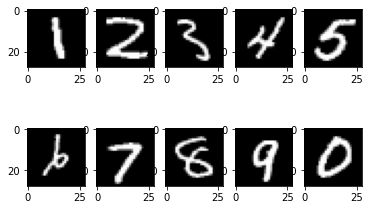

In [101]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5)
k = 0
sample_x = [0, 47, 87, 123, 187, 230, 270, 300, 340, 470]
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(np.reshape(train_X[sample_x[k]], (28, 28)), cmap='gray')
        k += 1

## 1.3 Number Selector

Choose desired numbers to be extracted from the data

In [61]:
def extract_nums(input_x, input_y, nums, relabel = False):
    '''Return arrays in x and labels in y that match nums'''
    extracted_x = extracted_y = np.empty(0)
    for i in range(input_y.size):
        if input_y[i] in nums:
            extracted_x = np.append(extracted_x, input_x[i])
            extracted_y = np.append(extracted_y, input_y[i])
    total = extracted_y.size
    extracted_y = extracted_y.reshape((total, 1))
    extracted_x = extracted_x.reshape((total, int(extracted_x.size/total)))
    # if relabel is true, set y labels to 0 and 1 depending on nums
    # used for tuning gradient descent
    if relabel:
        extracted_y[extracted_y == nums[0]] = 0
        extracted_y[extracted_y == nums[1]] = 1
    return extracted_x, extracted_y

# 2. Bayesian Logisitic Regression Model

## 2.1 Gradient of Log Likelihood

talk about math

In [62]:

def gradient(input_x, input_y, beta, sigma):
    '''Calculate the gradient of log likelihood function'''
    # initialize beta as nx1 array where n = size of row
    num_points, image_size = input_x.shape
    sigma = 1
    dL = np.zeros((image_size, 1))
    # for each pixel
    for k in range(image_size):
        # for each image
        for i in range(num_points):
            x = input_x[i]
            y = input_y[i]
            first_term = 1 - y
            second_term = (math.e**np.matmul(-x, beta)[0])/(1 + math.e**np.matmul(-x, beta)[0])
            dL[k][0] += (first_term - second_term) * x[k]
        dL[k][0] += beta[k]/(sigma**2)
    return dL

## 2.2 Gradient Descent to Tune $\beta$

Tune $\beta$ by adding the gradient of the log likelihood function.

In [125]:
def gradient_descent(x, y):
    '''Return tuned beta after gradient descent'''
    image_size = x.shape[1]
    beta = np.ones((image_size, 1))
    sigma = 1
    # while the gradient is greater than 0.1
    for i in range(10):
        beta -= 0.1 * gradient(x, y, beta, sigma)
    # beta shape: 784x1
    return beta

## 2.3 Tune $\beta$ for All Combinations of X

Run gradient descent for log likelihood to tune $\beta$ for every binary combination of digits. Because of time constraints, the gradient descent is limited to 10 iterations. This entire process takes ~14 minutes to complete.

In [126]:
def beta_array(train_X, train_Y, nums):
    '''Return an array with all betas for each combination of X'''
    betas = np.ndarray(shape=(10, 10, train_X.shape[1], 1))
    
    for i in range(betas.shape[0] - 1):
        for j in range(i + 1, betas.shape[0]):
            if i != j:
                nums = (i, j)
                train_X_extracted, train_Y_extracted = extract_nums(train_X, train_Y, nums, True)
                betas[i][j] = gradient_descent(train_X_extracted, train_Y_extracted)
    return betas

In [111]:
nums = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
betas = beta_array(train_X, train_Y, nums)


## 2.4 Make Predictions

In [112]:
def predict(x, beta, nums):    
    '''Use beta to make prediction on input x given possible nums'''
    prediction = nums[0]
    for i in range(1, len(nums)):
        num1 = prediction
        num2 = nums[i]
        ber = 1/(1 + math.e**np.matmul(-x, beta[num1][num2])[0])
        if ber > 0.5:
            prediction = nums[i]
    return prediction

def map_predictions(test_X, test_Y, nums, betas):
    '''Use given beta array to predict all of test_X and return accuracy of test_Y'''
    predictions = np.zeros((test_X.shape[0], 1))
    # get predictions using beta
    for i in range(test_X.shape[0]):
        predictions[i][0] = predict(test_X[i], betas, nums)
    counter = 0
    # find number of correct predictions
    for i in range(test_X.shape[0]):
        if predictions[i][0] == test_Y[i][0]:
            counter += 1
    return round(100 * counter/predictions.shape[0], 2)

Accuracy for distinguishing between 0 and 1

In [113]:
nums = (0, 1)
test_X_0_1, test_Y_0_1 = extract_nums(test_X, test_Y, nums)
p_0_1 = map_predictions(test_X_0_1, test_Y_0_1, nums, betas)
print('{}%'.format(p_0_1))

96.52%


Accuracy for distinguishing between 0, 1, 2, 3, and 4

In [114]:
nums = (0, 1, 2, 3, 4)
test_X_0_1_2_3_4, test_Y_0_1_2_3_4 = extract_nums(test_X, test_Y, nums)
p_0_1_2_3_4 = map_predictions(test_X_0_1_2_3_4, test_Y_0_1_2_3_4, nums, betas)
print('{}%'.format(p_0_1_2_3_4))

80.23%


Accuracy for distinguishing between all numbers

In [127]:
nums = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
p = map_predictions(test_X, test_Y, nums, betas)
print('{}%'.format(p))

50.09%


## 2.5 Accuracy Calculation and Visualization

This is a heatmap of the accuracies of the binary classifiers.

In [115]:
accuracies = np.ndarray(shape = (10, 10))
for i in range(10):
    for j in range(10):
        if i != j and i < j:
            test_X_extracted, test_Y_extracted = extract_nums(test_X, test_Y, (i, j))
            accuracies[i][j] = map_predictions(test_X_extracted, test_Y_extracted, (i, j), betas)

Text(33.0, 0.5, 'First digit')

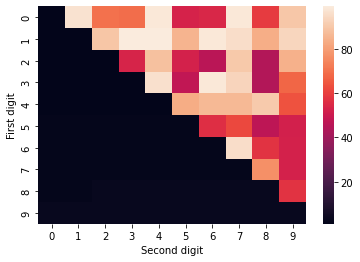

In [116]:
sns.heatmap(accuracies)
plt.xlabel('Second digit')
plt.ylabel('First digit')

In [117]:
sum = 0
count = 0

for i in range(accuracies.shape[0]):
    for j in range(accuracies.shape[1]):
        if i != j and i < j:
            count += 1
            sum += accuracies[i][j]
average = sum / count
print('Average: {}'.format(average))

Average: 74.52933333333333


In [118]:
sum = 0
count = 0

for i in range(accuracies.shape[0]):
    for j in range(accuracies.shape[1]):
        if i != j and i < j and accuracies[i][j] > 80:
            count += 1
            sum += accuracies[i][j]
average = sum / count
print('Average without outliers: {}'.format(average))

Average without outliers: 92.06304347826087


The average accuracy is 94.69%. There are 2 outliers: (3, 5) and (4, 9). Without these outliers, the average accuracy is 96.50%. These outliers are expected because the digits are very similar to one another. A more complex model is needed to better distinguish between these.

# 3. Principal Component Analysis

## 3.1 Extract Eigenvalues

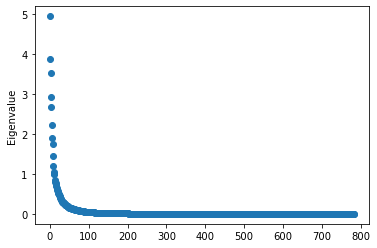

In [119]:
# get covariance
def cov(x, y):
    return np.sum((x - x.mean())*(y - y.mean()))/(len(x) - 1)

# get covariance matrix
def cov_mat(X):
    arr = np.zeros((X.shape[0], X.shape[1]))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            arr[i][j] = cov(X[i], X[j])
    return arr

col_mean = np.mean(train_X.T, axis=1)
covariance_matrix = np.cov(train_X.T - col_mean[:,None])
eigen_values_sorted = np.sort(np.linalg.eigh(covariance_matrix)[0])[::-1]

val_x = np.arange(0, eigen_values_sorted.shape[0])
plt.ylabel('Eigenvalue')
plt.scatter(val_x, eigen_values_sorted)

## 3.2 Total Variance

It takes 70 principal components to achieve at least 90% of the data variance


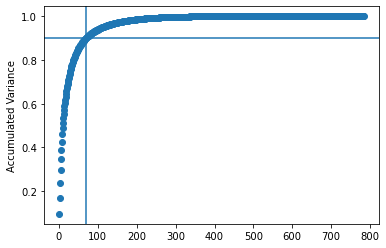

In [120]:
total_variance = np.sum(eigen_values_sorted)

data_variance = 0
counter = 0
sum_variance = 0
variance_x = []
variance_y = []

PCA = 0
PCA_data = 0
end = False

for ev in eigen_values_sorted:
    sum_variance += ev
    data_variance = sum_variance / total_variance
    counter += 1
    if end == False and data_variance > 0.9:
        end = True
        PCA = counter
        PCA_data = data_variance
    variance_x.append(counter)
    variance_y.append(data_variance)

plt.ylabel('Accumulated Variance')
plt.axvline(x = PCA)
plt.axhline(y = 0.9)
plt.scatter(variance_x, variance_y)
print('It takes %s principal components to achieve at least 90%% of the data variance' %PCA)

## 3.3 Eigenvectors with Highest Eigenvalues

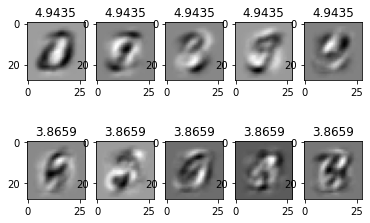

In [99]:
eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)

idx = eigen_values.argsort()[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]
fig,ax = plt.subplots(2, 5)
k = 0
for i in range(2):
    for j in range(5):
        ax[i][j].title.set_text(str(round(eigen_values[i], 4)))
        ax[i][j].imshow(np.reshape(eigen_vectors[:,k], (28, 28)), cmap='gray')
        k += 1

## 3.4 Apply PCA

Reduce the number of dimensions while keeping the variance between data points

In [121]:
def PCA(x, y, components):
    # get eigen values and vectors
    num_points = x.shape[0]
    col_mean = np.mean(x.T, axis=1)
    covariance_matrix = np.cov(x.T - col_mean[:,None])

    eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)

    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:,idx]

    # project each image onto eigen space
    projection = np.zeros((num_points, components))
    for i in range(num_points):
        for j in range(components):
            projection[i][j] = np.matmul(x[i].T, eigen_vectors[j])

    return projection, y

components = 70
train_X_reduced, train_Y_reduced = PCA(train_X, train_Y, components)
test_X_reduced, test_Y_reduced = PCA(test_X, test_Y, components)


## 3.5 Tune New $\beta$ for PCA

In [123]:
nums = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
betas_PCA = beta_array(train_X_reduced, train_Y_reduced, nums)

## 3.6 Make Predictions

Accuracy for distinguishing between all numbers after PCA

In [131]:
p = map_predictions(test_X_reduced, test_Y_reduced, nums, betas_PCA)
print('{}%'.format(p))

8.7%
